In [1]:
import stats
import compare_vcf as comp
from read_vcf import parse_vcf
import re

try: 
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]

# Generate fixed files if needed (fix coverage = None sniffle error)
except FileNotFoundError:
    pattern = r'(COVERAGE=[^;]*)(None)([^;]*;)'
    replacement = r'\g<1>0\g<3>'

    for i in range(1, 11):
        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.vcf', 'r') as infile:
            file_contents = infile.read()

        modified_contents = re.sub(pattern, replacement, file_contents)

        with open(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf', 'w') as outfile:
            outfile.write(modified_contents)
    
    data = [parse_vcf(f'data-p90/P90-{i}.trimed1000.sv_sniffles.fixed.vcf') for i in range(1, 11)]


### Plot basic statistics on variants

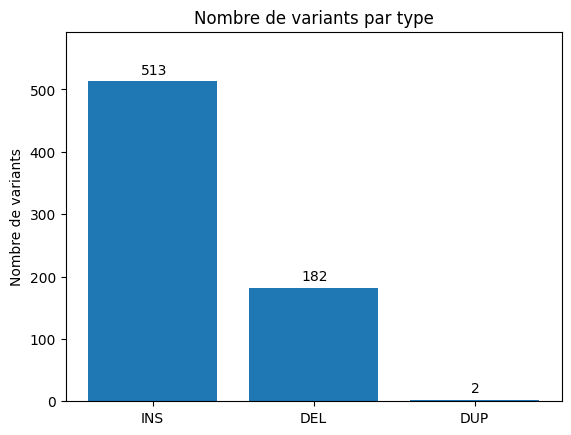

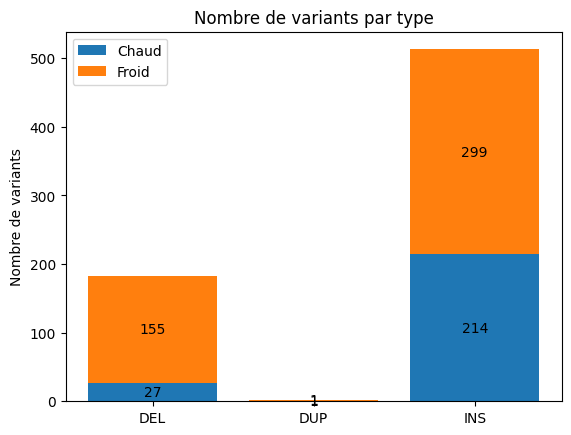

In [2]:
all_variant = sum(data, [])
heat_group = sum([data[i] for i in range(0, 4)], [])
cold_group = sum([data[i] for i in range(4, 10)], [])

counts_all = stats.count_by_type(all_variant)
counts_heat = stats.count_by_type(heat_group)
counts_cold = stats.count_by_type(cold_group)

grouped_labels = list( set(counts_heat.keys()).union(counts_heat.keys()) )
grouped_counts = {
    "Chaud": [counts_heat[k] if k in counts_heat else 0 for k in grouped_labels],
    "Froid": [counts_cold[k] if k in counts_cold else 0 for k in grouped_labels]
}

stats.plot_count_by_type(counts_all)
stats.plot_grouped_count_by_type(grouped_counts, grouped_labels)

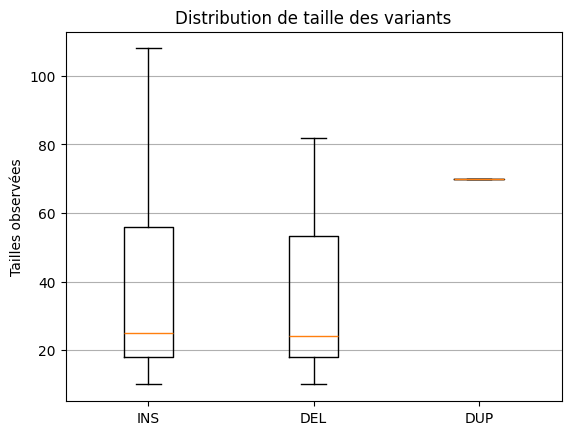

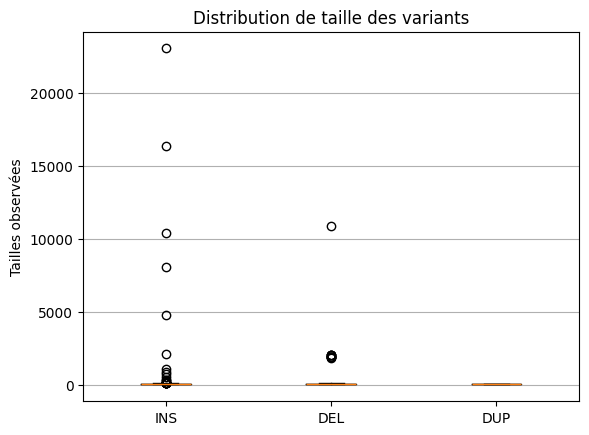

In [3]:
len_distrib_all = stats.len_by_type(all_variant)
stats.plot_len_by_type(len_distrib_all, False)
stats.plot_len_by_type(len_distrib_all, True)

### Plot similarity heatmap between samples

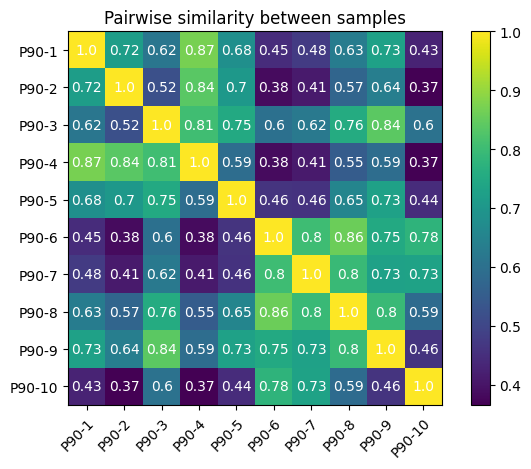

In [4]:
grouped_data = comp.group_variants(data, max_dist=0, min_sim=1)
sims = comp.pairwise_similarity(list(range(0, 10)), grouped_data)
comp.variant_heatmap(sims, [f"P90-{i}" for i in range(1, 11)])